In [1]:
import numpy as np

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from plot_data import *
from data_loading import *

from generate_data import DataGenerator

import json

from OT_predictor import *

seed_everything(42)

In [2]:
n_train = 1000
n_test = 1000
n_calibration = 1000

k = 2
d = 2
pert = "gaussian"
covariance_matrix = np.array([[1., 0.9], [0.9, 1.]])
data_generator = DataGenerator(d, k, pert, covariance_matrix = covariance_matrix)
y_train, y_test, y_calibration = data_generator.generate_perturbation_train_calibration_test(n_train, n_test, n_calibration)
y_test = y_train
y_calibration = y_train

average = torch.tensor( y_train.mean(axis=0) )

x_train_tensor = torch.ones((n_train, 1))
x_calibration_tensor = torch.ones((n_calibration, 1))
x_test_tensor = torch.ones((n_test, 1))

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_calibration_tensor = torch.tensor(y_calibration, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [3]:
import torch

class FixedModel:
    def __init__(self, value):
        self.value = value  # Tensor of shape (d,)
    
    def __call__(self, x):
        n = x.shape[0]
        return self.value.unsqueeze(0).expand(n, -1)
    
center_model = FixedModel(average)


In [4]:
alpha = 0.05

In [5]:
def get_idx(x,DATA,psi): 
    ''' Returns the image of `x` by the OT map parameterized by `psi` towards the empirical distribution of `sample_sort`.'''
    if (len(x.shape)==1):  
        to_max = (DATA @ x) - psi 
        res = DATA[np.argmax(to_max)]
    else: 
        to_max = (DATA @ x.T).T - psi 
        res = DATA[np.argmax(to_max,axis=1)]
    return (res)


def get_idx_mu(self, x_test, y_test):
    f_x = self.get_centers(x_test)
    res_test = y_test - f_x
    res_test = res_test.detach().cpu().numpy()
    x_test = x_test.detach().cpu().numpy()

    Quantile_Treshold,knn,scores_cal_1,mu = self.parameters_MK 
    n = self.n_neighbors

    if n != -1: 
        raise ValueError("n_neighbors must be -1 for this function to work properly.")
    
    prop = 0
    psi,psi_star = ot_functions.learn_psi(mu,scores_cal_1) 

    tab_idx = np.zeros((len(x_test), 2))

    for i in range(len(x_test)):
        s_tick = res_test[i]
        res = get_idx(s_tick,mu,psi)
        tab_idx[i] = res

    return tab_idx


In [6]:
ot_predictor = OTPredictor(center_model, -1 )
ot_predictor.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)

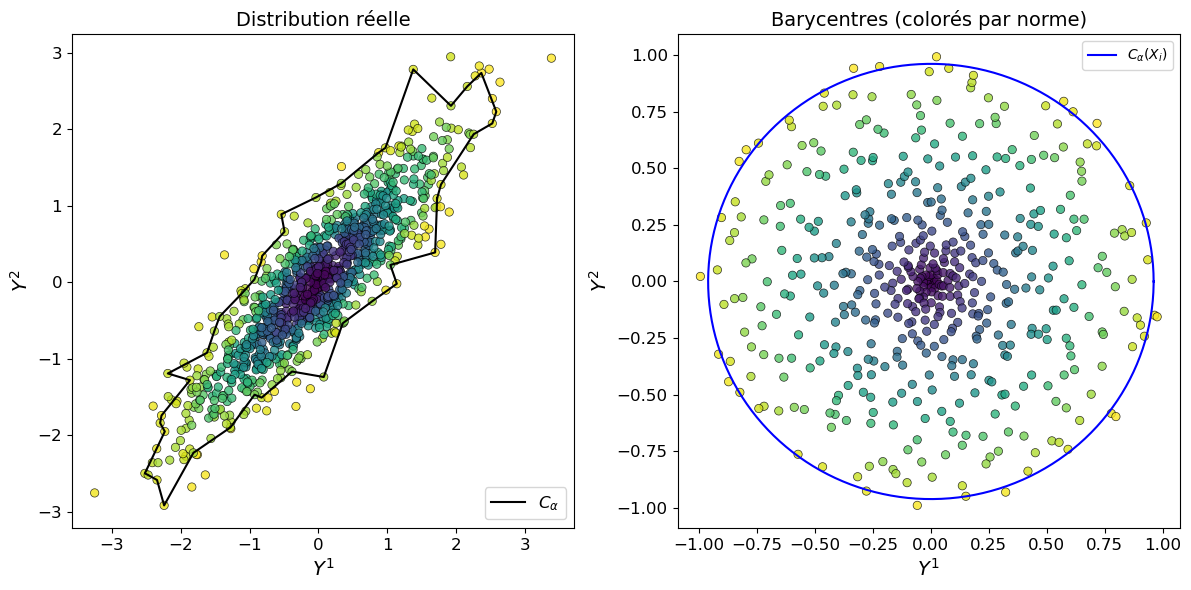

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.colors as colors

quantile_contours = ot_predictor.get_contour(x_test_tensor[0])[0]
Quantile_Treshold, _, _, mu = ot_predictor.parameters_MK

# --- Data ---
# mu : array (N, 2)
norms = np.linalg.norm(mu, axis=1)

# --- Colormap ---
cmap = cm.viridis
norm = Normalize(vmin=norms.min(), vmax=norms.max())

# --- Function to get the color of a vector mu_i ---
def get_color(mu_i):
    norm_value = np.linalg.norm(mu_i)
    return cmap(norm(norm_value))  # returns RGBA

# --- Apply colors ---
colors_mu = np.array([get_color(m) for m in mu])

corresponding_mu = get_idx_mu(ot_predictor, x_test_tensor, y_test_tensor)
colors_y = np.array([get_color(mu_corr) for mu_corr in corresponding_mu])

# --- Trace ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left : y_test + contour (unchanged)
quantile_contours = ot_predictor.get_contour(x_test_tensor[0])[0]
sc1 = axs[0].scatter(y_test[:, 0], y_test[:, 1], c=colors_y, alpha=0.8, edgecolor='k', linewidth=0.5)

axs[0].plot(quantile_contours[:, 0], quantile_contours[:, 1], color="black", linestyle='-', label=r'$C_\alpha$')
axs[0].set_xlabel(r'$Y^1$', fontsize=14)
axs[0].set_ylabel(r'$Y^2$', fontsize=14)
axs[0].set_title("Ree", fontsize=14)
axs[0].legend(fontsize=12, loc='lower right')
axs[0].tick_params(labelsize=12)

# Right : barycenters colored by norm
sc2 = axs[1].scatter(mu[:, 0], mu[:, 1], c=colors_mu, alpha=0.8, edgecolor='k', linewidth=0.5)
axs[1] = add_ellipse(axs[1],  np.array([0,0]), np.eye(2), 2.0, Quantile_Treshold, color = "blue",  label=fr'$C_\alpha(X_{{i}})$')
axs[1].set_xlabel(r'$Y^1$', fontsize=14)
axs[1].set_ylabel(r'$Y^2$', fontsize=14)
axs[1].set_title("Barycenters (colored by norm)", fontsize=14)
axs[1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()
plt.close()


In [ ]:
masque = (mu[:, 0] < -0.5) & (mu[:, 1] < -0.7)

indices = np.where(masque)[0]

print(indices)

idx_special = indices[0]

[476]


In [9]:
print(np.linalg.norm(mu[idx_special]))
print(Quantile_Treshold)

0.9539078156312626
0.9604008016032064


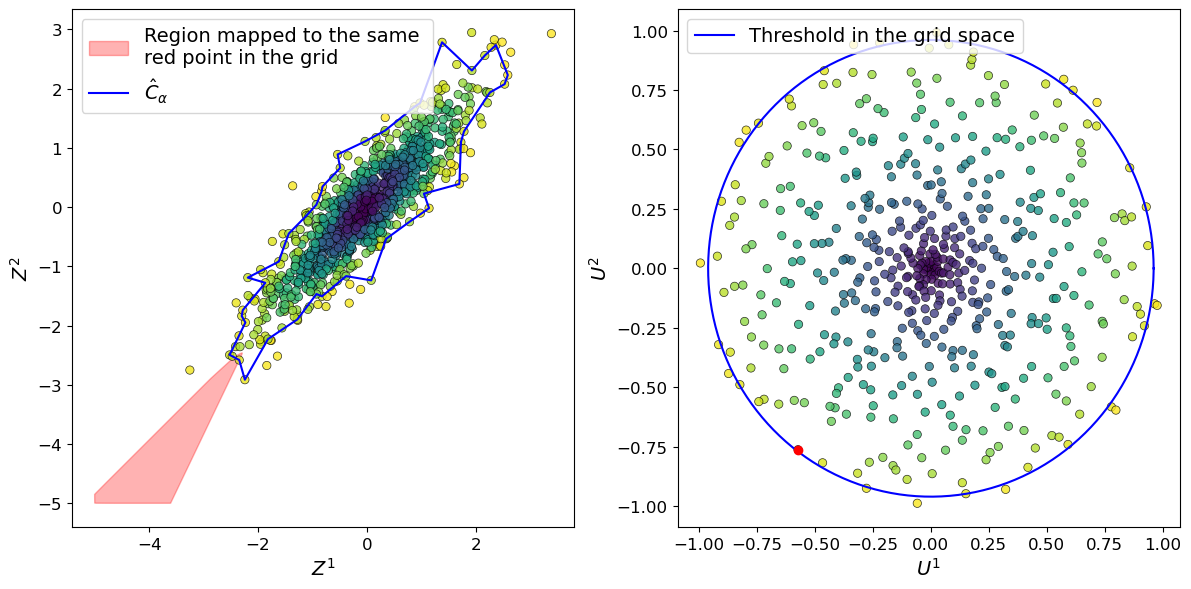

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.colors as colors

norm_value = 1.0
cmap = plt.get_cmap('Reds')
norm = colors.Normalize(vmin=0, vmax=1)
rgba_color = cmap(norm(norm_value))


quantile_contours = ot_predictor.get_contour(x_test_tensor[0])[0]
Quantile_Treshold, knn, scores_cal_1, mu = ot_predictor.parameters_MK
data_knn, psi_star = ot_functions.get_psi_star(x_test_tensor[0], knn, scores_cal_1, n_neighbors=-1, mu=mu)
transform_fronteer = ot_functions.T0(Quantile_Treshold*mu[idx_special] , data_knn ,psi_star) + ot_predictor.get_centers(x_test_tensor[0]).detach().cpu().numpy()
transform_fronteer += np.array([-0.5, -0.5])  # Adjusting the transformation to match the original data distribution

transform_fronteer_tensor = torch.tensor(transform_fronteer, dtype=torch.float32)
corresponding_mu_fronteer = get_idx_mu(ot_predictor, transform_fronteer_tensor, transform_fronteer_tensor)

# --- Data ---
# mu : array (N, 2)
norms = np.linalg.norm(mu, axis=1)

# --- Colormap ---
cmap = cm.viridis
norm = Normalize(vmin=norms.min(), vmax=norms.max())

# --- Function to get the color of a vector mu_i ---
def get_color(mu_i):
    norm_value = np.linalg.norm(mu_i)
    return cmap(norm(norm_value))  # returns RGBA

# --- Apply colors  ---
colors_mu = np.array([get_color(m) for m in mu])

colors_mu[idx_special] = rgba_color

corresponding_mu = get_idx_mu(ot_predictor, x_test_tensor, y_test_tensor)
colors_y = np.array([get_color(mu_corr) for mu_corr in corresponding_mu])

for i in range(len(colors_y)):
    if np.array_equal(corresponding_mu[i],mu[idx_special]):
        colors_y[i] = rgba_color

# --- Trace ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

import numpy as np

n_samples = 100000  

x_min, x_max = -5, -2
y_min, y_max = -5, -2

x_samples = np.random.uniform(x_min, x_max, n_samples)
y_samples = np.random.uniform(y_min, y_max, n_samples)

samples = np.column_stack((x_samples, y_samples))

x_samples = torch.tensor(samples, dtype=torch.float32)
inside = np.array(ot_predictor.get_inside(x_samples, x_samples))


corresponding_mu_samples = get_idx_mu(ot_predictor, x_samples, x_samples)

indices = np.where(corresponding_mu_samples[:, 0] == mu[idx_special, 0] )[0]

from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

# Points to consider
points = samples[indices]

# Compute the convex hull
hull = ConvexHull(points)

# Add the polygon to the axis
polygon = Polygon(points[hull.vertices], closed=True, color='red', alpha=0.3, label='Region mapped to the same \nred point in the grid')
axs[0].add_patch(polygon)


# Left : y_test + contour (unchanged)
quantile_contours = ot_predictor.get_contour(x_test_tensor[0])[0]
sc1 = axs[0].scatter(y_test[:, 0], y_test[:, 1], c=colors_y, alpha=0.8, edgecolor='k', linewidth=0.5)
axs[0].plot(quantile_contours[:, 0], quantile_contours[:, 1], color="blue", linestyle='-', label=r'$\hat{C}_\alpha$')
axs[0].set_xlabel(r'$Z^1$', fontsize=14)
axs[0].set_ylabel(r'$Z^2$', fontsize=14)
# axs[0].set_title(r"$Z_i$", fontsize=14)
axs[0].legend(fontsize=14, loc='upper left')
axs[0].tick_params(labelsize=12)

# Right : barycenters colored by norm
sc2 = axs[1].scatter(mu[:, 0], mu[:, 1], c=colors_mu, alpha=0.8, edgecolor='k', linewidth=0.5)
axs[1] = add_ellipse(axs[1],  np.array([0,0]), np.eye(2), 2.0, Quantile_Treshold, color = "blue",  label=fr'Threshold in the grid space')
axs[1].scatter(corresponding_mu_fronteer[:, 0], corresponding_mu_fronteer[:, 1], c='red', zorder=10)
corresponding_mu_fronteer
axs[1].set_xlabel(r'$U^1$', fontsize=14)
axs[1].set_ylabel(r'$U^2$', fontsize=14)
axs[1].tick_params(labelsize=12)
axs[1].legend(fontsize=14, loc='upper left')

plt.savefig(f"../figs/failure_mode_OT.png", dpi = 300, bbox_inches='tight')
plt.savefig(f"../figs/failure_mode_OT.pdf", dpi = 300, bbox_inches='tight')

plt.tight_layout()
plt.show()
plt.close()
